# Notebook 4: ETF Closing Price Prediction (Part 2) - using Multiple (20) RF Regression Models

## Objectives ##
- As per the Business Requirement Email, we will try to satisfy the additional/optional requirement
- To do so, we need to find a way to run and collate the results for multiple predictive models
- From earlier test results - we will also use a different testing strategy - only using the Target ETF Close Price against pure FRED Macroeconomic Indicator data 

## Input(s)
- CSV file containing just pivoted ETF Close Price, with ETF Tickers as Features on one file
- The other file will be FRED Macroeconomic Indicator data only
- Unlike before, these files will be kept separate (read unmerged) and brough together during the ML phase


## Output(s)
- Regression Metrics (R-Squared and Root Mean Squared Error (RMSE)) - Using a Random Forrest Regressor
- Various data visualisation plots based on the above

## Project Time Constraints
- Please note that as this is a 'nice-to-have' and it generally summarises all the tools used earlier on in other notebooks - we will only comment on new code/coding strategies

## Use of AI Declaration
- As coding multiple regression models are out of scope of this course, I declare that I used AI to assist me with building and debugging the codes used below
- Please see the Credit (Perplexity AI) section on the README file for further details on where AI was used to complete this project
- In accordance with the course guidelines I will confirm WHERE I have used AI and WHAT I used it for 

## Section 1: A Reminder of the results we're trying to achieve and the core Hypotheses for this project
- <mark>Acceptable Accucacy R-Squared scores: over 90%</mark>

### Core Hypotheses (what we intend to prive)
- <mark>H0: Machine Learning ETF (H2 and H3) predictions accuracy relies heavily on macroeconomic data</mark>
- <mark>H1: Most ETF close prices and price direction are heavily influenced by GDP data figures</mark> 
- <mark>H2: Most ETF close prices are accurately predicted using just macroeconomic data</mark>
- H3: Most ETF price directions are accurately predicted, again using just macroeconomic data

### Core Hypotheses Validation Methods (what we will  use to prove the above)
- <mark>V0: Classical Machine Learning: Parallel testing datasets with and without macroeconomic data</mark>
- <mark>V1: Classical Machine Learning: Regression (Linear) & Classification plus Feature Selection</mark>
- <mark>V2: Classical Machine Learning: Regression (Linear) plus Feature Selection</mark>
- V3: Feature Engineering & Classical Machine Learning: Random Forrest Classification plus Feature Selection

## Section 2: Import Python Libraries

In [ ]:
# Usual imports for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# For Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# For Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Make graphs look nice
plt.style.use('seaborn-v0_8-whitegrid')

# Check the current working directory
import os
print(os.getcwd()) 

c:\Users\tishs\vscode-projects\etf-close-price\jupyter_notebooks


## Section 3: Load and check the 'special' ETF Market Data File (no features added)
- This file was constructed specially for this task and is not utilised anywhere else
- It's essentially a CSV file for pivoted data: with ETF Tickers as the columns and rows of ETF Close Prices (see below for a look)
- The Date field is used as the index and also included in the file to provide a way to link it with the FRED indicator file which we will load next

In [ ]:
df1 = pd.read_csv("../resources/pivoted_files/close_pivot.csv")             

In [3]:
df1.shape, df1.head()

((1507, 21),
          Date        BND        EFA        HYG       ITOT         IVV  \
 0  2020-01-02  70.398941  58.637085  64.169525  67.128349  298.040710   
 1  2020-01-03  70.650444  57.909763  64.104156  66.715912  295.748138   
 2  2020-01-06  70.566612  58.135498  64.038727  66.972557  296.917114   
 3  2020-01-07  70.507881  57.976639  63.980587  66.761749  296.104370   
 4  2020-01-08  70.398941  58.143845  64.038727  67.064232  297.611389   
 
           IWD         IWF         IWM         MDY  ...       QQQE        SKY  \
 0  121.286797  171.524551  153.706009  349.545654  ...  51.578495  32.110001   
 1  120.472488  170.283920  153.103394  347.723328  ...  51.106380  32.060001   
 2  120.578690  171.370651  153.307343  347.713898  ...  51.143421  32.049999   
 3  120.215782  171.014801  152.797379  346.756256  ...  51.365589  31.719999   
 4  120.472488  172.428574  153.270233  347.379333  ...  51.671047  32.049999   
 
           TLT        VEU         VOO         VTI    

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1507 non-null   object 
 1   BND     1507 non-null   float64
 2   EFA     1507 non-null   float64
 3   HYG     1507 non-null   float64
 4   ITOT    1507 non-null   float64
 5   IVV     1507 non-null   float64
 6   IWD     1507 non-null   float64
 7   IWF     1507 non-null   float64
 8   IWM     1507 non-null   float64
 9   MDY     1507 non-null   float64
 10  QQQ     1507 non-null   float64
 11  QQQE    1507 non-null   float64
 12  SKY     1507 non-null   float64
 13  TLT     1507 non-null   float64
 14  VEU     1507 non-null   float64
 15  VOO     1507 non-null   float64
 16  VTI     1507 non-null   float64
 17  XLE     1507 non-null   float64
 18  XLF     1507 non-null   float64
 19  XLK     1507 non-null   float64
 20  XLV     1507 non-null   float64
dtypes: float64(20), object(1)
memory usag

In [5]:
df1["Date"] = pd.to_datetime(df1["Date"], format='mixed', dayfirst=True)

In [6]:
df1.head()

,Date,BND,EFA,HYG,ITOT,IVV,IWD,IWF,IWM,MDY,...,QQQE,SKY,TLT,VEU,VOO,VTI,XLE,XLF,XLK,XLV
0,2020-01-02,70.398941,58.637085,64.169525,67.128349,298.040710,121.286797,171.524551,153.706009,349.545654,...,51.578495,32.110001,115.443726,45.335087,272.760468,151.060059,23.508690,27.785067,44.349251,92.685555
1,2020-01-03,70.650444,57.909763,64.104156,66.715912,295.748138,120.472488,170.283920,153.103394,347.723328,...,51.106380,32.060001,117.221626,44.760498,270.767822,150.098618,23.438839,27.490051,43.850632,91.877869
2,2020-01-06,70.566612,58.135498,64.038727,66.972557,296.917114,120.578690,171.370651,153.307343,347.713898,...,51.143421,32.049999,116.555954,44.843758,271.782318,150.611420,23.621227,27.472170,43.955105,92.449615
3,2020-01-07,70.507881,57.976639,63.980587,66.761749,296.104370,120.215782,171.014801,152.797379,346.756256,...,51.365589,31.719999,115.983025,44.777138,271.032776,150.254288,23.559135,27.293371,43.936111,92.268097
4,2020-01-08,70.398941,58.143845,64.038727,67.064232,297.611389,120.472488,172.428574,153.270233,347.379333,...,51.671047,32.049999,115.216187,44.885395,272.431305,150.995972,23.171074,27.472170,44.406242,92.867050


## Section 4: Load and check the FRED Macroeconomic Indicator dataset (no features added)

In [7]:
df2 = pd.read_csv(r"..\resources\raw_files\fred\fred_macro_data.csv")

In [8]:
df2["Date"] = pd.to_datetime(df2["Date"], format='mixed', dayfirst=True)

In [9]:
df2.head(), df2.shape

(        Date        GDP  CPI_Inflation  Average_price_of_eggs  \
 0 2020-01-03  21751.238        259.127                  1.461   
 1 2020-01-04  21751.238        259.127                  1.461   
 2 2020-01-05  21751.238        259.127                  1.461   
 3 2020-01-06  21751.238        259.127                  1.461   
 4 2020-01-07  21751.238        259.127                  1.461   
 
    Average_price_of_electricity  Leading_Index_for_US  \
 0                         0.134                  1.57   
 1                         0.134                  1.57   
 2                         0.134                  1.57   
 3                         0.134                  1.57   
 4                         0.134                  1.57   
 
    NBER_Recession_Indicator  Producer_Price_Index  5-Year_Breakeven_Inflation  \
 0                       0.0                 199.3                        1.85   
 1                       0.0                 199.3                        1.85   
 2    

## Section 5: Matching the two Datasets Using their respecive Date Features
- We had a big challenge doing so using the raw FRED indicator file - as the data for this was collected everyday, whereas the ETF Market data only had trading days, which excluded weekends and public holidays
- We tried using special pandas functions to pull back just the dates we needed from FRED - however this solution had its own issues
- In the end, we used an MS Excel 'VLOOKUP' method - by selecting the dates from the ETF Market file and using this to pull-back into a new dataframe JUST the dates that matched, we got 99% (see below) of the data needed.   

In [10]:
#create a list from the smaller ETF close dataframe to match against the bigger Economic Indicator dataframes on same dates - so as to pull back only matching dates - otherwise this won't work
date_matcher = df1["Date"].tolist()

In [11]:
df2.shape

(2190, 47)

In [12]:
df2 = df2[df2["Date"].isin(date_matcher)] #filtering df2 to only use dates that match those in df1

In [13]:
df1.shape, df2.shape # just one record off - close enough match to successfully proceed

((1507, 21), (1506, 47))

In [14]:
etf_list = df1.columns.to_list()

In [15]:
print(etf_list)

['Date', 'BND', 'EFA', 'HYG', 'ITOT', 'IVV', 'IWD', 'IWF', 'IWM', 'MDY', 'QQQ', 'QQQE', 'SKY', 'TLT', 'VEU', 'VOO', 'VTI', 'XLE', 'XLF', 'XLK', 'XLV']


## Section 6: Machine Learning BUT with a 'Slight Tweak'
- Unlike earlier ML Models - the above created a new challenge, as datasets were kept separate and not merged
- Therefore, We amended the code to match the two datasets based on their date and Ticker names
- Again, this cause some serious breakages earlier during coding, as both sets of dataframes needed to match EXACTLY on dates (see above Excel VLOOKUP approach - finally resolved this) 

In [ ]:
#as before, set date as index for both dataframes
df1.set_index('Date', inplace=True)
df2.set_index('Date', inplace=True)

etf_list = df1.columns.to_list()

#Catch-all feature to ensure the dates line up correctly
same_dates = df1.index.intersection(df2.index)

#combining the dataframes based on the matching dates and tickers
feature_cols = df2.loc[same_dates].select_dtypes(include=['number']).columns
X = df2.loc[same_dates, feature_cols].values
Y = df1.loc[same_dates, etf_list].values

feature_names = feature_cols.tolist()

## Section 7: Multiple Results using a For Loop and Amending the Machine Larning Model (Random Forrest Regressor)
- Thoughts behind this - if we can run the same training/test datasets in multiple ML Models (see gauge accuracy & determine which one to use), why can't we generate multiple train/test models using one ML model?
- Used a for loop to do so and put all the results we needed into a 'result' dictionary 

In [ ]:
## *** AI assisted me with building and debugging the below code: to use a for-loop to train multiple models and extract from those models multiple sets of predicted results ***
results = {}                                                                    #this is where we will store the results
for i, etf in enumerate(etf_list):
    y = Y[:, i]
    
    X_train, X_test, y_train, y_test = train_test_split(                        #usual train-test 80:20 split
        X, 
        y, 
        test_size=0.2, 
        shuffle=True, 
        random_state=42
    )
    
    rf = RandomForestRegressor(n_estimators=500, 
                               random_state=42, 
                               n_jobs=-1)
    
    rf.fit(X_train, y_train)                                                    #fit the model for each ETF
    
    y_pred = rf.predict(X_test)                                                 #make predictions frpm the test set & collate results in the results dictionary
    results[etf] = {
        "model": rf,
        "r2": r2_score(y_test, y_pred),
        "rmse": root_mean_squared_error(y_test, y_pred),
        "y_test": y_test,
        "y_pred": y_pred
    }
## ***

In [ ]:
#display the results - for audit trail and inspection before moving on to visualizations
for etf, metrics in results.items():
    print(f"{etf}: R²={metrics['r2']:.3f}, RMSE={metrics['rmse']:.3f}")

BND: R²=0.995, RMSE=0.260
EFA: R²=0.996, RMSE=0.767
HYG: R²=0.996, RMSE=0.394
ITOT: R²=0.998, RMSE=1.049
IVV: R²=0.999, RMSE=4.016
IWD: R²=0.998, RMSE=1.428
IWF: R²=0.998, RMSE=3.683
IWM: R²=0.994, RMSE=2.509
MDY: R²=0.995, RMSE=5.813
QQQ: R²=0.998, RMSE=4.934
QQQE: R²=0.997, RMSE=0.841
SKY: R²=0.991, RMSE=1.956
TLT: R²=0.999, RMSE=0.765
VEU: R²=0.996, RMSE=0.506
VOO: R²=0.999, RMSE=3.667
VTI: R²=0.998, RMSE=2.352
XLE: R²=0.995, RMSE=0.787
XLF: R²=0.998, RMSE=0.457
XLK: R²=0.998, RMSE=1.139
XLV: R²=0.994, RMSE=1.309


## Section 8: Using Data Visualisation to Analyse and Compare each ETF by their Metric Results

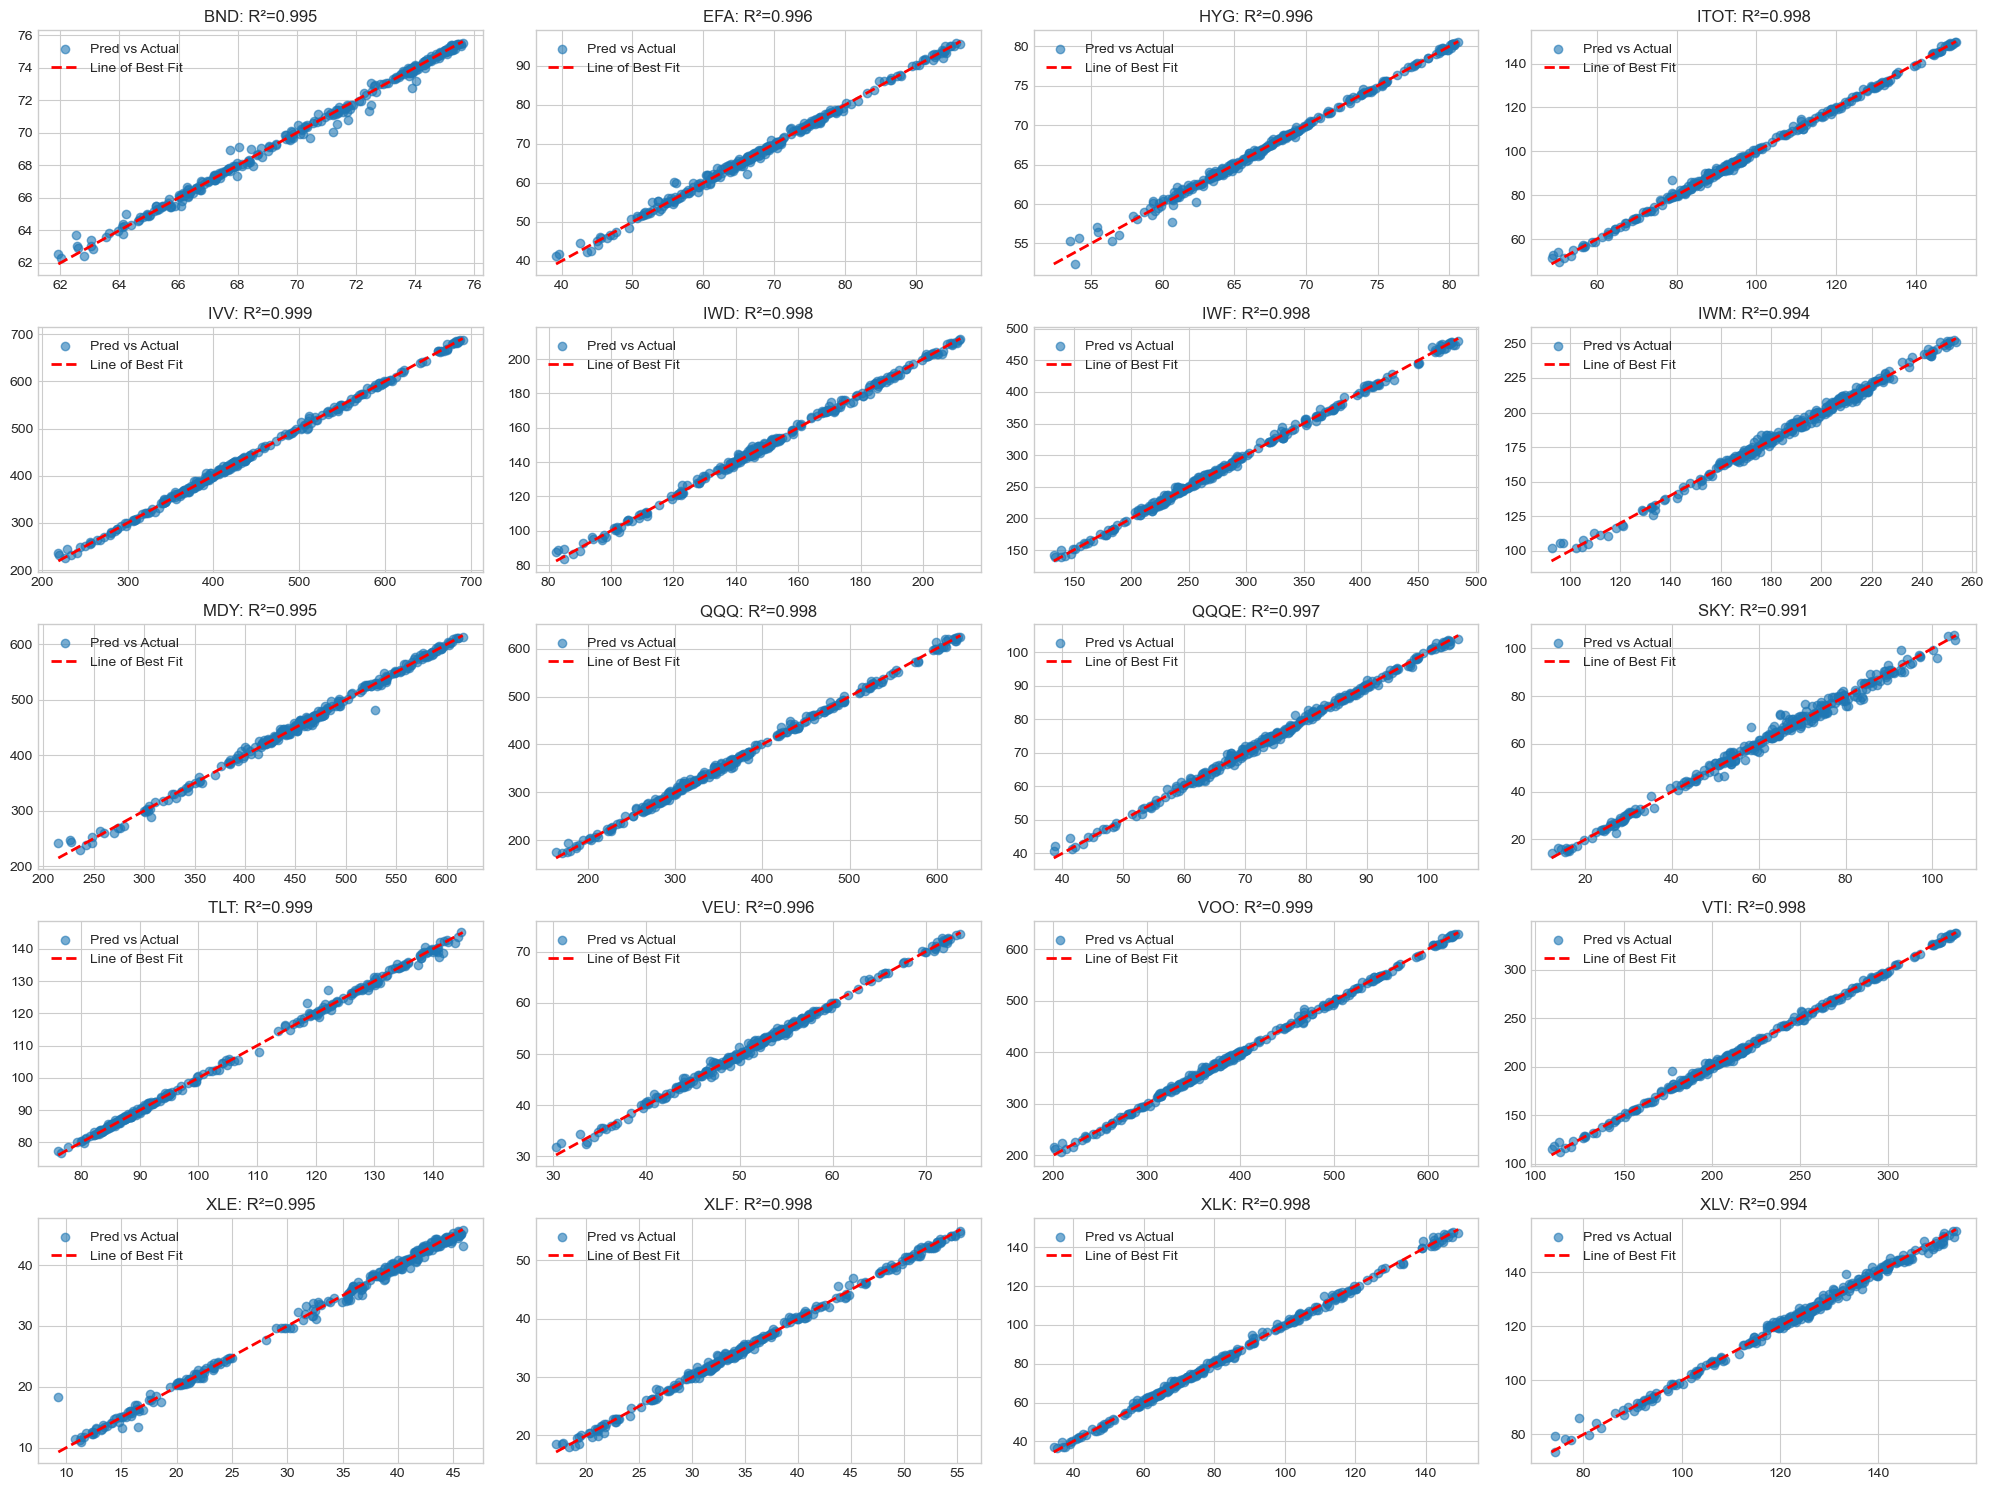

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15))                                                #create a 5x4 grid of subplots - one for each of the 20 ETFs
axes = axes.flatten()                                                                           #for comments - please see earlier notebooks
## *** AI assisted me with building and debugging the below code: amending the usual plot codes making it applicable to 20 ETFs ***
for i, etf in enumerate(etf_list[:20]):
    ax = axes[i]
    y_test = results[etf]['y_test']
    y_pred = results[etf]['y_pred']
    
    ax.scatter(y_test, 
               y_pred, 
               alpha=0.6, 
               label='Pred vs Actual')
    
    min_val = min(y_test.min(), 
                  y_pred.min())
    max_val = max(y_test.max(), 
                  y_pred.max())
    ax.plot([min_val, 
             max_val], 
            [min_val, 
             max_val], 
            'r--', 
            lw=2, 
            label='Line of Best Fit')
    
    ax.set_title(f"{etf}: R²={results[etf]['r2']:.3f}")
    ax.legend() 

plt.tight_layout()
plt.show()
## ***

## Section 9: Using Data Visualisation to Analyse and Compare each ETF by their Close Price (Actuals vs Predictions)

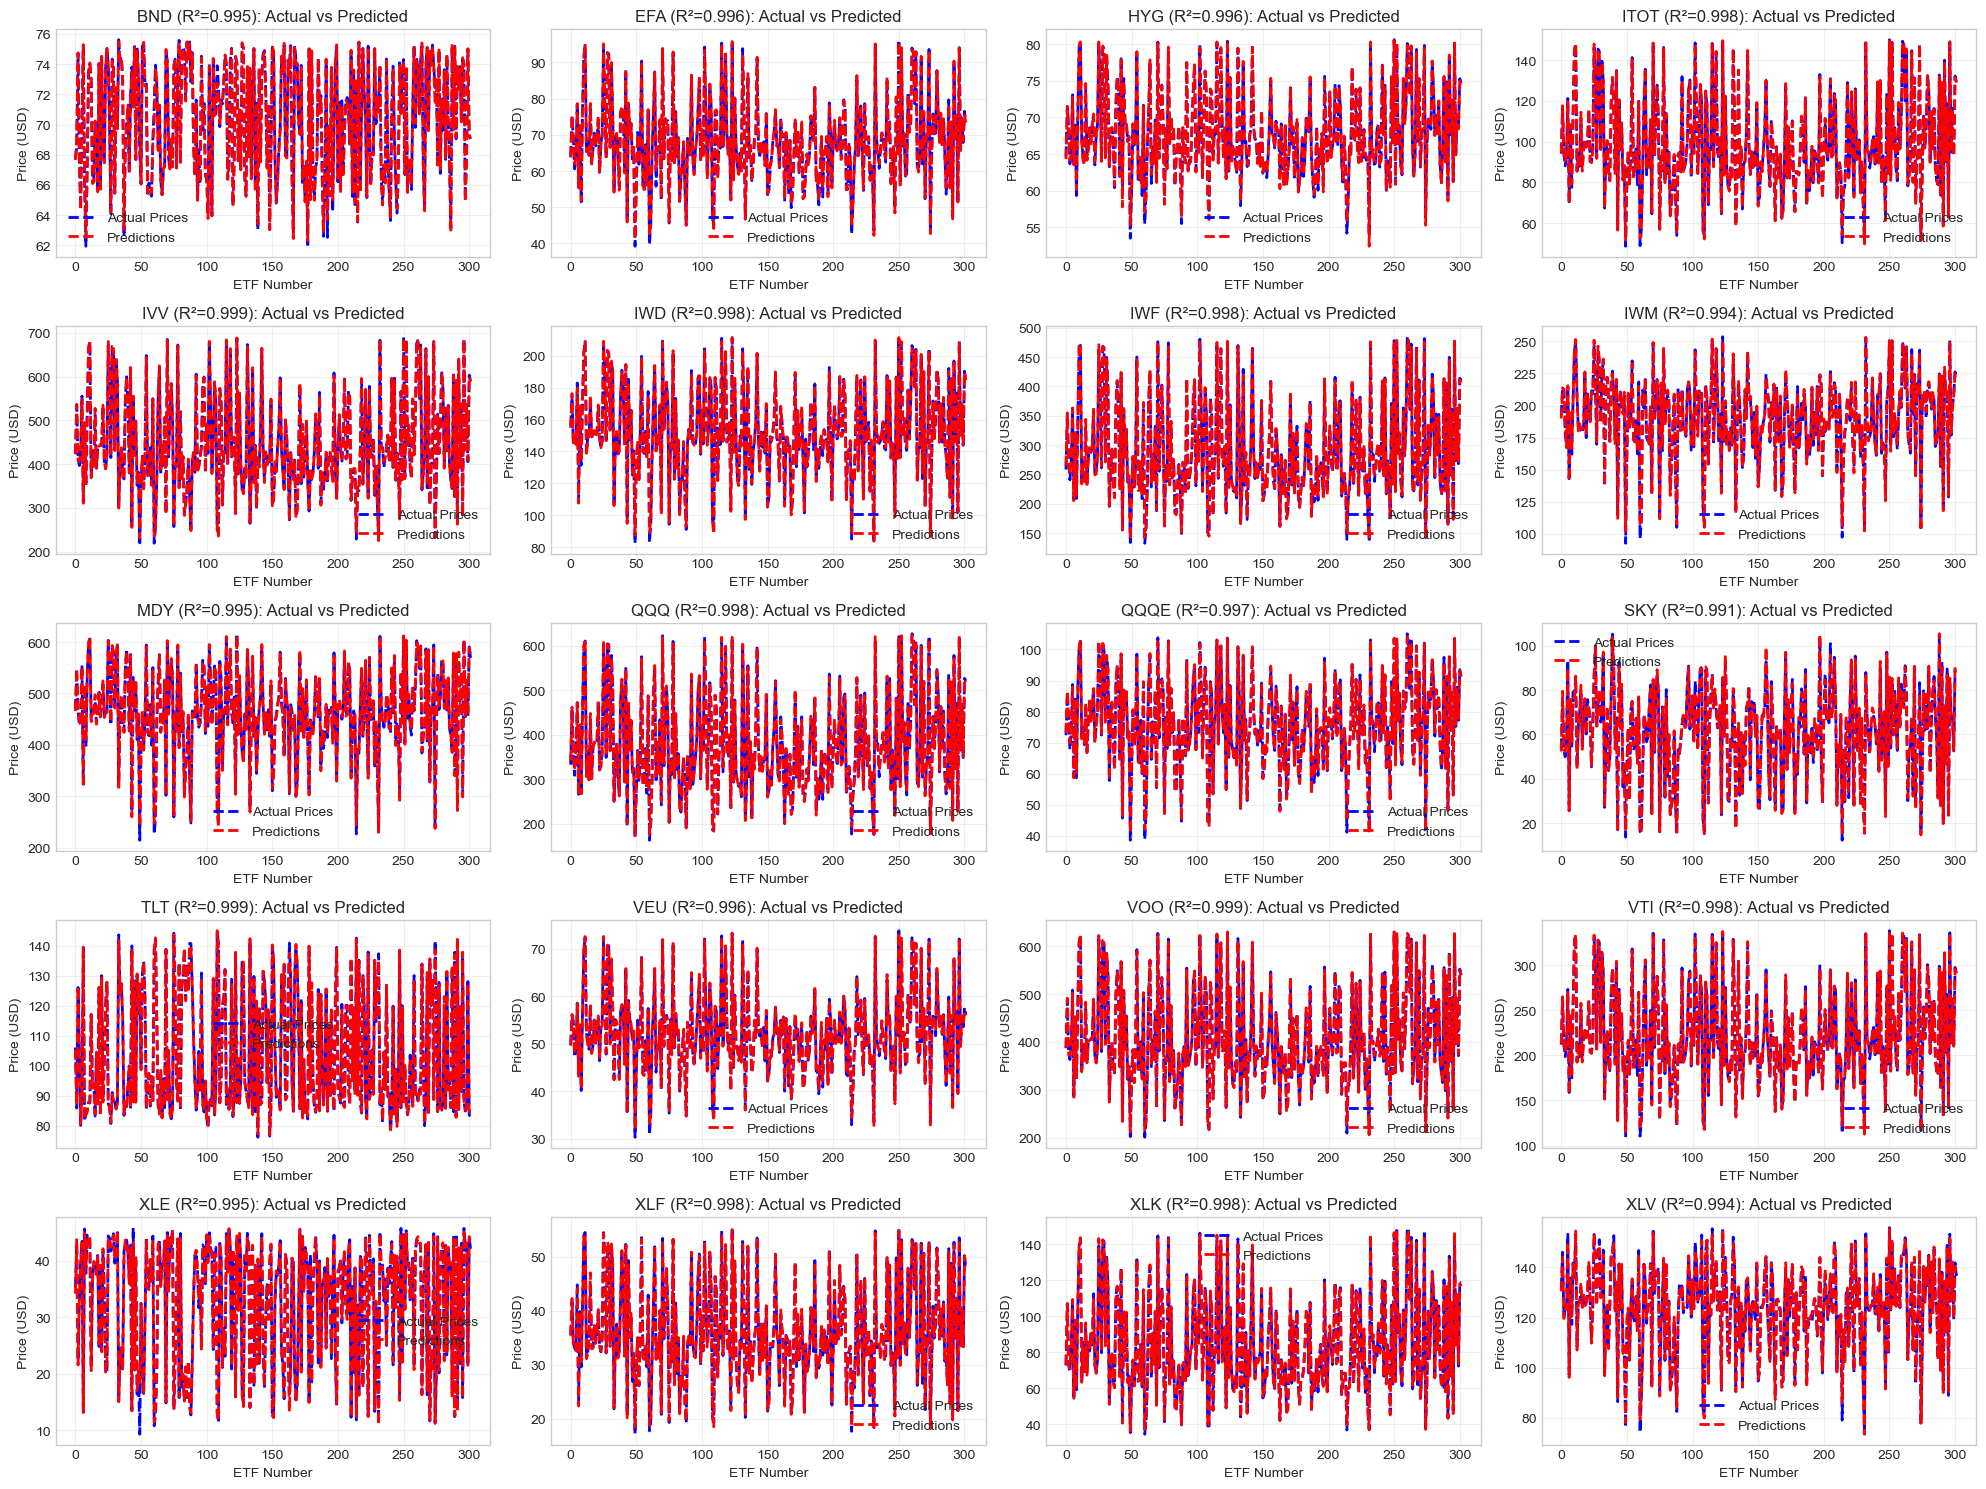

In [ ]:
# Simple line plot - Actual vs Predicted
## *** AI assisted me with building and debugging the below code: amending the usual plot codes making it applicable to 20 ETFs ***
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

for i, etf in enumerate(etf_list[:20]):
    ax = axes[i]
    y_test = results[etf]['y_test']
    y_pred = results[etf]['y_pred']
    
    x_axis = np.arange(len(y_test)) 
    
    ax.plot(x_axis, 
            y_test, 
            'b--', 
            label='Actual Prices', 
            linewidth=2)
    
    ax.plot(x_axis, 
            y_pred, 
            'r--', 
            label='Predictions', 
            linewidth=2)
    
    ax.set_xlabel('ETF Number')
    ax.set_ylabel('Price (USD)')
    ax.set_title(f'{etf} (R²={results[etf]['r2']:.3f}): Actual vs Predicted')
    ax.legend()
    ax.grid(True, alpha=0.3)
## ***

plt.tight_layout()
plt.show()

## Section 10: Using Data Visualisation to Analyse and Compare each ETF by their Feature Importance

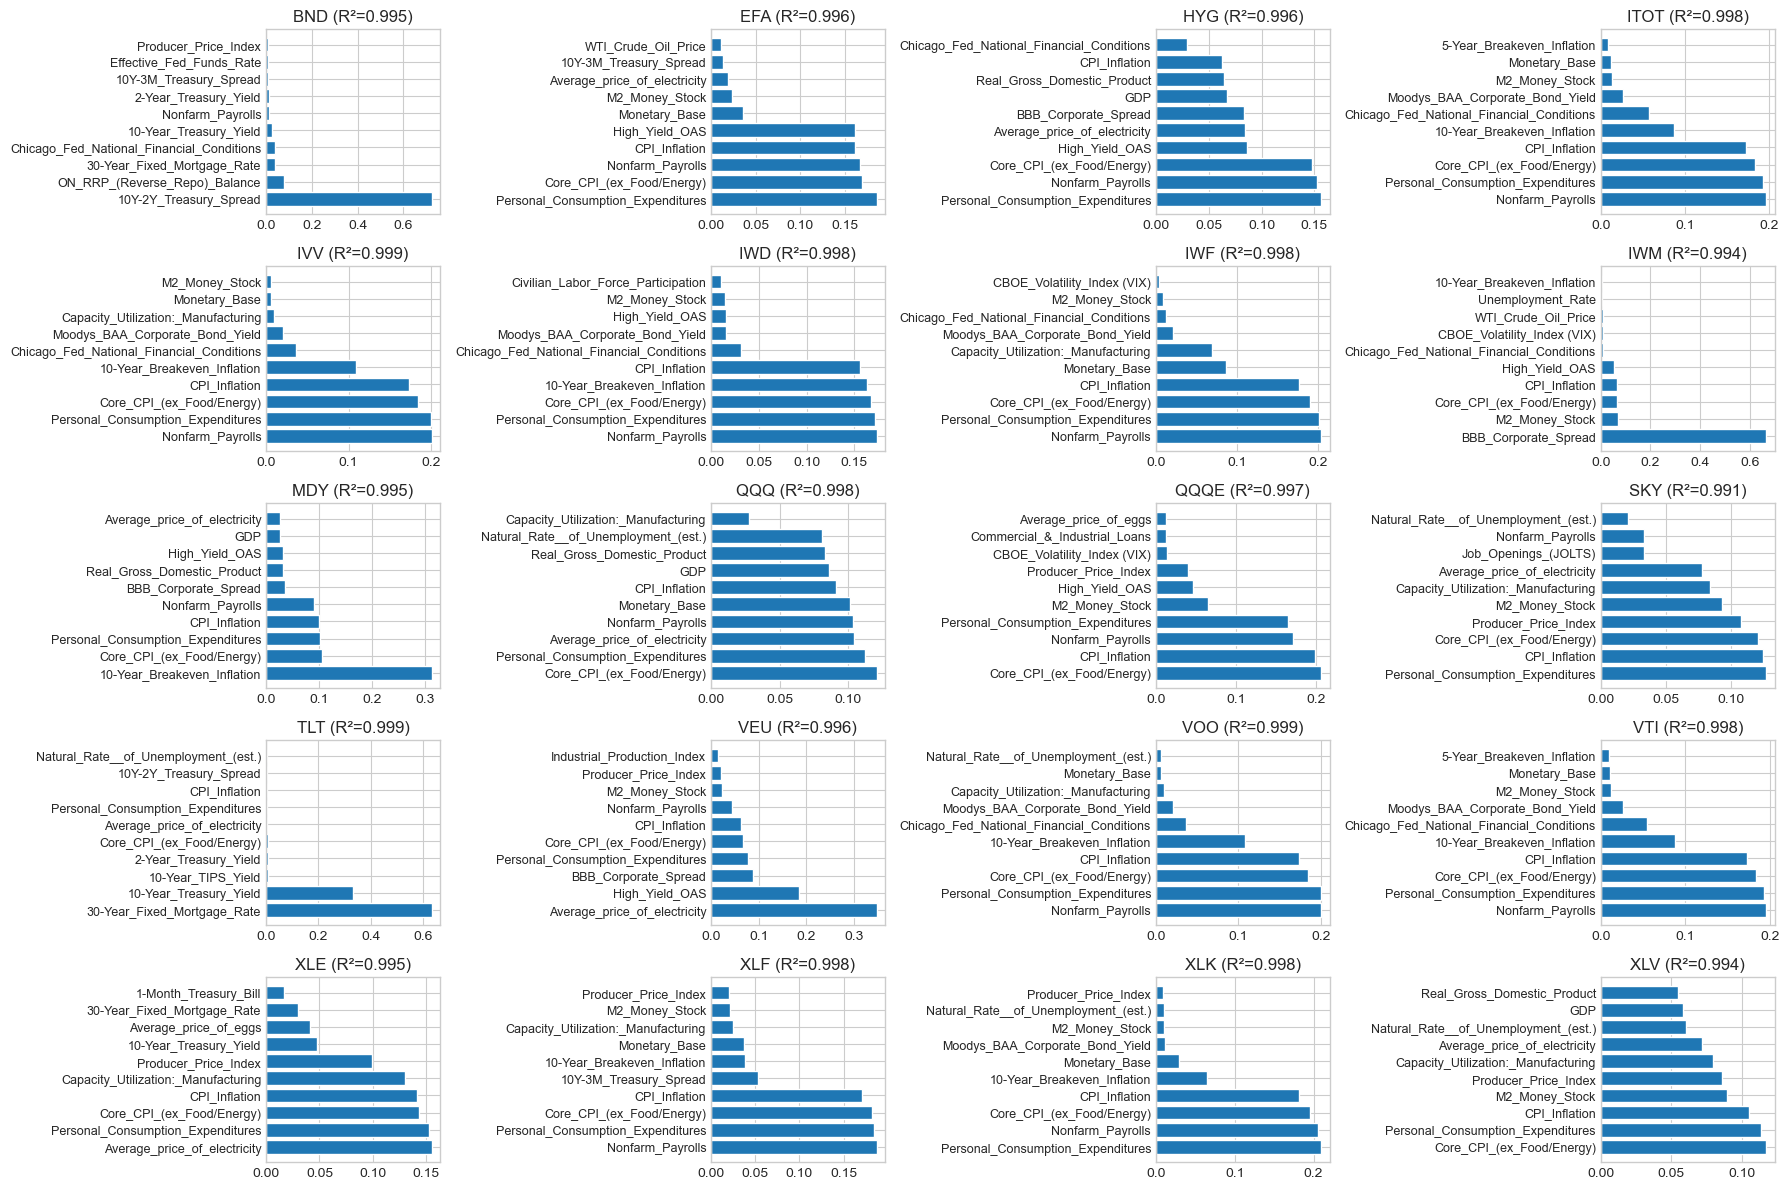

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(18, 12))
axes = axes.flatten()
## *** AI assisted me with building and debugging the below code: amending the usual plot codes making it applicable to 20 ETFs ***
for idx, etf in enumerate(etf_list[:20]):
    ax = axes[idx]
    model = results[etf]['model']
    importances = model.feature_importances_
    top_idx = np.argsort(importances)[-10:]
    
    ax.barh(range(10), 
            importances[top_idx])
    ax.set_yticks(range(10))
    ax.set_yticklabels([feature_names[i] for i in top_idx], fontsize=9)
    ax.set_title(f"{etf} (R²={results[etf]['r2']:.3f})")
    ax.invert_yaxis()
## ***
plt.tight_layout()
plt.show()

## Section 10: Using Data Visualisation the top 10 Features Averaged across 20 ETFs 

In [22]:
imp_df = pd.DataFrame()

for etf in etf_list[:20]:
    model = results[etf]['model']
    importances = model.feature_importances_
    top_idx = np.argsort(importances)[-10:]  # Top 10 per ETF
    df_temp = pd.DataFrame({
        'feature': [feature_names[i] for i in top_idx],
        'importance': importances[top_idx],
        'etf': etf
    })

    imp_df = pd.concat([imp_df, df_temp], ignore_index=True)

# Average importance across ETFs (for features appearing in top 10)
mean_imp = imp_df.groupby('feature')['importance'].mean().sort_values(ascending=False).head(10)

In [27]:
print(f"{mean_imp*100}")

feature
10Y-2Y_Treasury_Spread               36.251956
30-Year_Fixed_Mortgage_Rate          23.357018
BBB_Corporate_Spread                 21.894553
Personal_Consumption_Expenditures    15.266838
Nonfarm_Payrolls                     14.629000
Core_CPI_(ex_Food/Energy)            14.436104
10-Year_Treasury_Yield               13.426938
CPI_Inflation                        13.113697
10-Year_Breakeven_Inflation          10.845834
Average_price_of_electricity          9.880150
Name: importance, dtype: float64


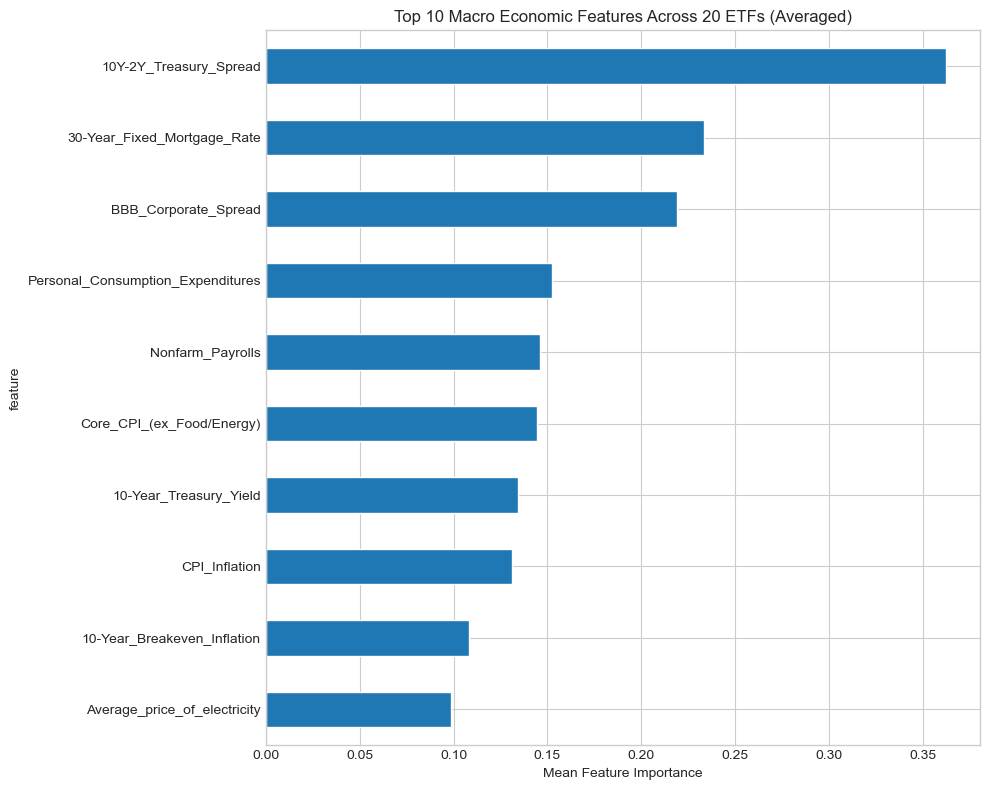

In [28]:
plt.figure(figsize=(10, 8))
mean_imp.plot(kind='barh')
plt.xlabel('Mean Feature Importance')
plt.title('Top 10 Macro Economic Features Across 20 ETFs (Averaged)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Core Hypotheses - addressed using the above
- H0: Machine Learning ETF (H2 and H3) predictions accuracy relies heavily on macroeconomic data - H0 is proven correct and therefore hypthesis is satisfied 
- H1: Most ETF close prices and price direction are heavily influenced by GDP data figures - some are but from above GDP on average doesn't make the top 10 - so H1 is disproved - hypothesis is incorrect 
- H2: Most ETF close prices are accurately predicted using just macroeconomic data - this notebook shows that only FRED indicator data is needed to provide accurate ETF closing price - hypothesis is correct and is satisfied
- H3: Most ETF price directions are accurately predicted, again using just macroeconomic data - from notebook 3 - this is partially true - and will need further tests to demonstrate this hypothesis is 100% correct